In [1]:
#import os, sys
#from google.colab import drive
#drive.mount('/content/drive')


packages installed on google drive so they don't have to be reloaded

In [2]:
#nb_path = '/content/drive/MyDrive/colab/privgwas/fuzzy-gwas/'
#sys.path.insert(0,nb_path)

%cd /content/drive/MyDrive/colab/privgwas/fuzzy-gwas/
#!pip3 install --target=$nb_path pickle5
#!pip3 install --target=$nb_path pycuda
#!pip install scikit-cuda
# need below version of torch to solve CUDA memory bug
#!pip install torch==1.9.0 torchvision==0.10.0

/content/drive/MyDrive/colab/privgwas/fuzzy-gwas


In [3]:
# need below version of torch to solve CUDA memory bug
#!pip install torch==1.9.0 torchvision==0.10.0

In [4]:
%cd /content/drive/MyDrive/colab/privgwas/fuzzy-gwas/
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from factorization_mechanism import *
import pdb
from matplotlib import pyplot
import pickle5 as pickle
import math
import pycuda.autoinit 
import pycuda.gpuarray as gpuarray
from skcuda import linalg




/content/drive/MyDrive/colab/privgwas/fuzzy-gwas


/content/drive/MyDrive/colab/privgwas/fuzzy-gwas/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


Execute the below for a subset of chr22 from HapMap3.

In [40]:
# Hap3, 1KG
dataset = 'Hap3'

if dataset == 'Hap3':
  with open('Data/query_submatrix.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    query_matrix = pickle.load(f)
if dataset == '1KG':
  data_dir = "Data/1KG/"
  with open(data_dir + '1kg_chr22_block17.pickle', 'rb') as f:
      query_matrix = pickle.load(f)
  # 52 is max
  for n in range(18, 40):
    with open(data_dir + '1kg_chr22_block' + '{}.pickle'.format(n), 'rb') as f:
      next_matrix = pickle.load(f)
      query_matrix = np.vstack((query_matrix, next_matrix))
  del next_matrix





In [41]:
query_matrix = query_matrix[:,0:500]
m, n = query_matrix.shape
print({'shape': (m, n)})
print({'noise added from gauss roughly': np.round(np.max(np.linalg.norm(query_matrix, axis=1))/n, 3)})


{'shape': (1000, 100)}
{'noise added from gauss roughly': 0.194}


Create pytorch dataset class.

In [42]:
class SNPDataset(Dataset):
    def __init__(self, query_matrix):
        self.query_matrix = torch.tensor(query_matrix)
    def __len__(self):
        return self.query_matrix.shape[0]
    def __getitem__(self, idx):
        return self.query_matrix[idx, :], idx



Create custom pytorch factorization module. 

Goal: Factor query_matrix = $LR^T $ such that $LR^T \approx Q$ and
$||R||_1$ and $||L||_1$ are low (low row norm for L, R)

First attempt: two separate variables L, R, optimize using alternating gradient descent, where we optimize the function
$$||LR^{T}-Q||_1 + \lambda*||R||_1*||L||$$




In [90]:
class Factorization(torch.nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, m, n, k, eps, delta):
        super(Factorization, self).__init__()
        # initialize weights with random numbers
        weights_L = torch.distributions.Uniform(0, 0.1).sample((m, k))
        weights_R = torch.distributions.Uniform(0, 0.1).sample((n, k))
        # make weights torch parameters
        self.weights_L = torch.nn.Parameter(weights_L)
        self.weights_R = torch.nn.Parameter(weights_R)
        self.eps = eps
        self.delta = delta

    def forward(self, ids):
        q_hat = torch.matmul(self.weights_L, torch.transpose(self.weights_R, 0, 1))
        return q_hat[ids,:], self.weights_L, self.weights_R


    def rand_init(self, shape, k_components=0): 
        m, n = shape
        if k_components == 0: 
          k_components = min(m,n)
        L = torch.tensor(np.random.rand(m, k_components))  
        R = torch.tensor(np.random.rand(n, k_components))
        self.weights_R = torch.nn.Parameter(R)
        self.weights_L = torch.nn.Parameter(L)

    def pca_init(self, query_matrix, k_components, cuda=False):
          if cuda: 
            skcuda.linalg.init()
            query_matrix_gpu = gpuarray.to_gpu(np.asarray(query_matrix, np.complex64))
            # skcu.linalg.svd must have n > m
            if query_matrix_gpu.shape[1] >= query_matrix.shape[0]:
              U_gpu, s_gpu, Vh_gpu = skcuda.linalg.svd(query_matrix_gpu, 'S', 'S')
            else: 
              u_gpu , s_gpu, v_gpu = skcuda.linalg.svd(np.transpose(query_matrix_gpu), 'S', 'S')
            
            U = np.transpose(v_gpu.get())
            S = np.diag(s_gpu.get())
            V_t = np.transpose(u_gpu.get())
            if not np.allclose(query_matrix_gpu, np.dot(U, np.dot(S, V_t)), 1e-4):
                raise ValueError("inaccurate svd")

            U_k = U[:, range(k_components)]
            S_k = S[range(k_components)]
            V_kh = V_t[range(k_components), :]
            self.weights_L = torch.nn.Parameter(torch.tensor(np.matmul(U_k, S_k)))
            self.weights_R = torch.nn.Parameter(torch.tensor(V_kh))
          else:
            svd = np.linalg.svd(query_matrix, full_matrices=False, compute_uv=True)
            U = svd[0]
            s = svd[1]
            Vh = svd[2]
            U_k = U[:, range(k_components)]
            S_k = np.diag(s[range(k_components)])
            V_kh = torch.tensor(Vh[range(k_components), :])
            self.weights_L = torch.nn.Parameter(torch.tensor(np.matmul(U_k, S_k)))
            self.weights_R = torch.nn.Parameter(torch.transpose(V_kh, 0, 1))
        
          return U_k, S_k, V_kh


# If M = LR^T-X, and if our loss fn is the MSE then the loss can be upper bounded by
# 1/m * (||M||_F^2*1/n + 1/n^2||L||_F^2||R||_{1->2}^2*privacy_blah
# Frobenius norms can be replaced with the spectral norm, set p = '2'
def loss_fn_l_2(outputs, q_ids, epsilon=1.0, delta = 1e-6, silent=False, p='fro'):
    
    q_hat, L, R = outputs
    m = L.shape[0]
    n_samp = q_ids.shape[0]
    approximation_loss = (1/np.power(n_samp, 2)*torch.pow(torch.linalg.matrix_norm(q_hat - q_ids, ord=p), 2))
    sigma = gaussian_mech_noise(torch.max(torch.norm(R, dim=1)), epsilon, delta, tensor=True)
    noise_loss = (1/np.power(n, 2)) * torch.pow(torch.linalg.matrix_norm(L, ord=p), 2)*torch.pow(sigma, 2)
    

    if not silent:
        appx_loss = approximation_loss.detach().cpu()
        nss_loss = noise_loss.detach().cpu()
        fn_value = np.round(appx_loss + nss_loss, 6)
        if math.isnan(appx_loss):
          raise ValueError("approximate loss is NaN")
          
        print('objective value: {}, squared loss from approximation error: {}, squared loss from noise: {}'.format(fn_value,
                                                                                     np.round(appx_loss,6),
                                                                                     np.round(nss_loss, 6)))
    return approximation_loss + noise_loss


def training_loop(dataloader, model, loss, optimizer, device):
    "Training loop for torch model."
    for batch, (q, ids) in enumerate(dataloader):

        # send data to device 
        q, ids = q.to(device), ids.to(device)

        # check for non_zero queries 
        if torch.sum(q) == 0:
          continue
        # zero gradients before minibatch
        optimizer.zero_grad()

        outputs = model(ids)
 
        # Compute prediction and loss
        loss = loss_fn_l_2(outputs, q, epsilon=model.eps, delta=model.delta, silent=False)
        # Backpropagation
        loss.backward()
        optimizer.step()
        # delete q, ids to free up gpu memory 
        del q, ids, outputs



Set parameters for training. 

In [94]:

training_data = SNPDataset(query_matrix)

if dataset == 'Hap3':
  bsize = 128
  epochs = 5000
  eps = 10.0
  delta = 1.0/np.power(n,2)
  learning_rate = 1.0/m
  k = min(m,n)
  mm_fac = Factorization(m, n, k, eps=eps, delta=delta)
  mm_fac.pca_init(query_matrix, k_components=k)

if dataset == '1KG':
  bsize = 1024
  epochs = 1
  eps = 10.0
  delta = 1.0/np.power(n,2)
  learning_rate = 1e-3
  # number of components to start factorization with
  k = 1000
  mm_fac = Factorization(m, n, k, eps=eps, delta=delta)
  mm_fac.rand_init(shape = (m, n), k_components=k)

Define the model, move it to device (GPU if available) and initialize via PCA. 

In [95]:
 # create data loader
train_dataloader = DataLoader(training_data, batch_size=bsize, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)





cuda:0


In [96]:
mm_fac = mm_fac.to(device)
optimizer = torch.optim.SGD(mm_fac.parameters(), lr=learning_rate)

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  training_loop(train_dataloader, mm_fac, loss_fn_l_2, optimizer, device)
print("Done!")



Streaming output truncated to the last 5000 lines.
-------------------------------
objective value: 0.316362, squared loss from approximation error: 0.224179, squared loss from noise: 0.092183
objective value: 0.310806, squared loss from approximation error: 0.21866, squared loss from noise: 0.092146
objective value: 0.311314, squared loss from approximation error: 0.219161, squared loss from noise: 0.092153
objective value: 0.318082, squared loss from approximation error: 0.22594, squared loss from noise: 0.092143
objective value: 0.31106, squared loss from approximation error: 0.218952, squared loss from noise: 0.092108
objective value: 0.311871, squared loss from approximation error: 0.219781, squared loss from noise: 0.09209
objective value: 0.310015, squared loss from approximation error: 0.217923, squared loss from noise: 0.092092
objective value: 0.361627, squared loss from approximation error: 0.269537, squared loss from noise: 0.09209
Epoch 4502
-------------------------------

In [97]:
# bring back the model 
mm_fac = mm_fac.cpu()
y = generate_y(query_matrix)


In [98]:
epsilon = mm_fac.eps
output = gaussian_mechanism_fac(mm_fac.weights_L.detach().numpy(), mm_fac.weights_R.detach().numpy(), query_matrix, y, epsilon=epsilon, delta=mm_fac.delta)
naive_gauss = gaussian_mech_matrix(query_matrix, y, epsilon=epsilon, delta=mm_fac.delta)
baseline_ldp = ldp_mechanism(query_matrix, y, epsilon=epsilon, delta=1 / n)
fac_rmse = np.round(np.sqrt(np.mean(np.power(output['private']-output['non_private'], 2))), 4)
ldp_rmse = np.round(np.sqrt(np.mean(np.power(baseline_ldp['private']-baseline_ldp['non_private'], 2))), 4)
gauss_rmse = np.round(np.sqrt(np.mean(np.power(naive_gauss['private']-naive_gauss['non_private'], 2))), 4)
gauss_medape = np.round(medape(naive_gauss['non_private'], naive_gauss['private']),4)
ldp_medape = np.round(medape(baseline_ldp['non_private'], baseline_ldp['private']),4)
fac_medape = np.round(medape(output['non_private'], output['private']),4)

In [80]:
torch.cuda.empty_cache()
#del mm_fac, train_dataloader, query_matrix

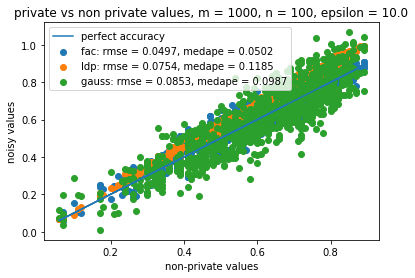

In [99]:


pyplot.scatter(output['non_private'], output['private'], label='fac: rmse = {}, medape = {}'.format(fac_rmse, fac_medape))
pyplot.plot(output['non_private'], output['non_private'], label='perfect accuracy')
pyplot.ylabel('noisy values')
pyplot.xlabel('non-private values')
pyplot.title('private vs non private values, m = {}, n = {}, epsilon = {}'.format(m, n, epsilon))
pyplot.scatter(output['non_private'], baseline_ldp['private'], label='ldp: rmse = {}, medape = {}'.format(ldp_rmse, ldp_medape))
pyplot.scatter(naive_gauss['non_private'], naive_gauss['private'], label='gauss: rmse = {}, medape = {}'.format(gauss_rmse, gauss_medape))
pyplot.legend()
pyplot.show()
